## Import Files

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))


from src.preprocessing import bandpass_filter
from src.feature_extraction import extract_time_features, extract_freq_features
from src.classical_ml import train_classical_models
from src.lstm_model import ECG_LSTM

## Dataset Acquisition & Understanding

Here, i imported the Waveform Database and used matplotlib library to plot a Raw ECG Signal

In [2]:
import wfdb
import matplotlib.pyplot as plt


In [3]:
record = wfdb.rdrecord('100', pn_dir='mitdb')
signal = record.p_signal[:, 0]   # Use Lead 1


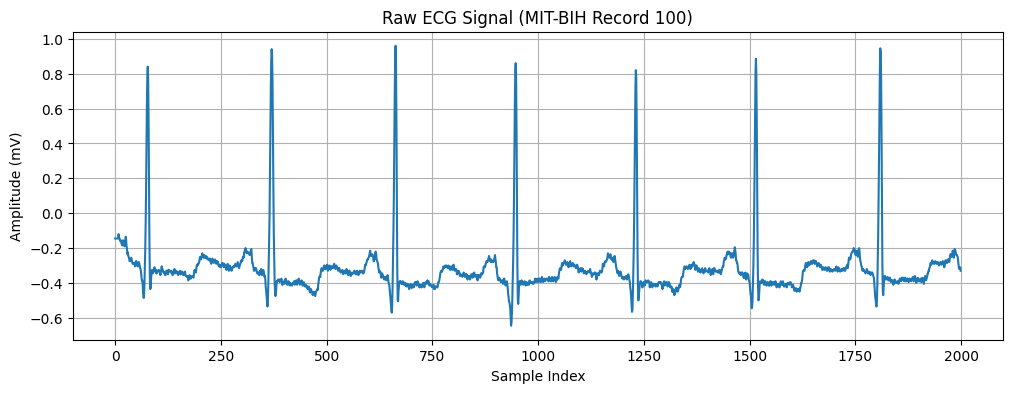

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(signal[:2000])
plt.title("Raw ECG Signal (MIT-BIH Record 100)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.savefig("../results/plots/raw_ecg_signal.png", dpi=300, bbox_inches="tight")
plt.show()

- Electrocardiogram is a graphical recording of your heart's electrical activity, showing how it beats by capturing tiny voltage changes on the skin using electrodes.
- An ECG is a time series because it's a sequence of electrical signals measured over time, capturing the heart's changing activity (depolarization/repolarization) as electrical impulses travel through it.
- A normal heartbeat when represented as an ECG signal looks like a repeating pattern of distinct peaks and valleys known as the PQRST complex.
- ECG waveforms usually show a wide variety of noises, primarily Baseline Wander (respiration/movement), Power Line Interference (50/60 Hz hum), Muscle Artifacts (EMG noise) from muscle activity, and Motion Artifacts from poor electrode contact or body shifts, plus random Gaussian White Noise.
- Sampled at 360Hz, thereby 2000samples is approx. 5-6 seconds of normal heart activity.

## Signal Preprocessing

### Why Preprocessing is mandatory ?
Raw ECG (Step 2) contains:

1. Baseline drift
- Very low-frequency (< 0.5 Hz)
- Caused by respiration, motion

2. High-frequency noise
- Muscle activity (EMG)
- Measurement noise
- Power-line harmonics

3. Useful ECG content
- Mostly between 0.5 Hz and 40 Hz

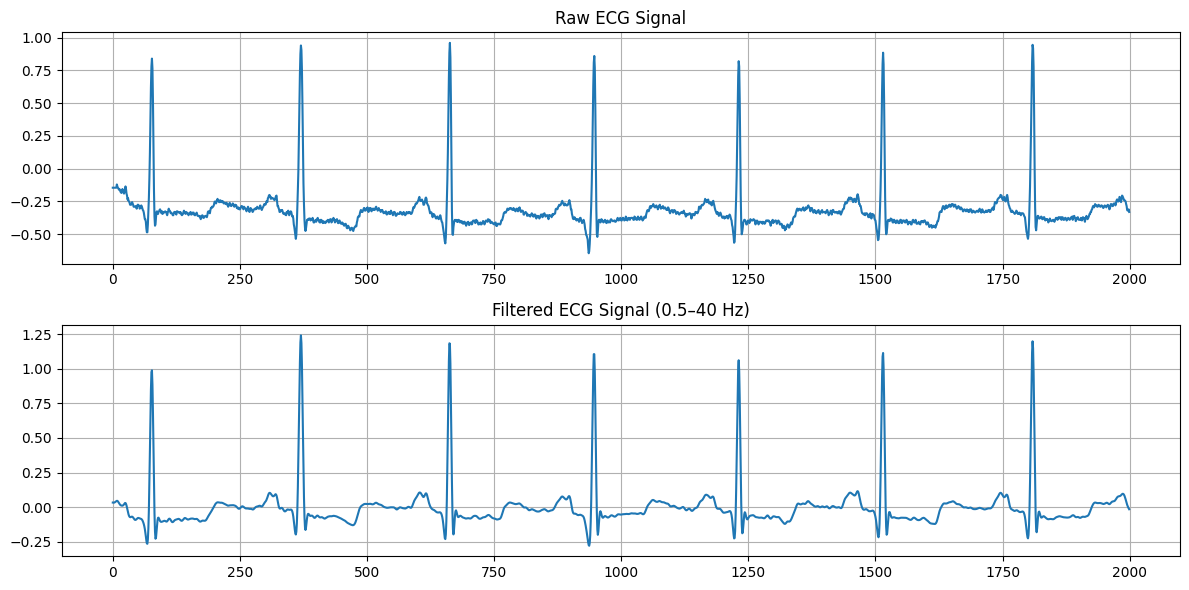

In [5]:
from scipy.signal import butter, filtfilt

def bandpass_filter(ecg_signal, fs=360, lowcut=0.5, highcut=40):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(N=4, Wn=[low, high], btype='band')
    filtered_ecg = filtfilt(b, a, ecg_signal)
    return filtered_ecg

filtered_signal = bandpass_filter(signal)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(signal[:2000])
plt.title("Raw ECG Signal")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(filtered_signal[:2000])
plt.title("Filtered ECG Signal (0.5–40 Hz)")
plt.grid(True)

plt.tight_layout()
plt.savefig("../results/plots/raw_ecg_signal.png", dpi=300, bbox_inches="tight")
plt.show()


## Heartbeat Segmentation
ECG signal is:

- Continuous
- Long
- Variable in length

ML models require:

- Fixed-size inputs
- Meaningful physiological units

In [6]:
# Load annotations
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')
r_peaks = annotation.sample

In [7]:
# Extract heartbeats
beats = []

window_size = 180 #total 360 samples in 1sec

for r in r_peaks:
    if r - window_size >= 0 and r + window_size < len(filtered_signal):
        beat = filtered_signal[r - window_size : r + window_size] #180 samples before and after R
        beats.append(beat)


In [8]:
# Convert array to ML-ready format
import numpy as np

beats = np.array(beats)
print(beats.shape)

(2271, 360)


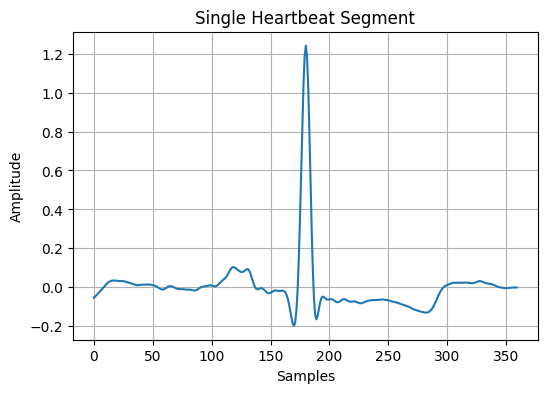

In [26]:
# Visualization 
plt.figure(figsize=(6, 4))
plt.plot(beats[0])
plt.title("Single Heartbeat Segment")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.savefig("../results/plots/heartbeat_segmentation.png", dpi=300, bbox_inches="tight")
plt.show()

## Feature Extraction

### Why time-domain features ? 
They capture:
- Amplitude variations
- Signal energy
- Morphology differences

### Features extracted here
For each heartbeat, compute:
- Mean
- Variance
- Root Mean Square (RMS)
- Peak-to-peak amplitude

In [10]:
def extract_time_features(beat):
    mean_val = np.mean(beat)
    var_val = np.var(beat)
    rms_val = np.sqrt(np.mean(beat**2))
    ptp_val = np.ptp(beat)  # peak-to-peak
    return [mean_val, var_val, rms_val, ptp_val]

time_features = np.array([extract_time_features(beat) for beat in beats])
print(time_features.shape)


(2271, 4)


### Why frequency-domain ? 
- ECG abnormalities often alter frequency content
- QRS → higher frequency
- P & T → lower frequency

In [11]:
def extract_freq_features(beat, num_coeffs=10):
    fft_vals = np.fft.fft(beat)
    mag = np.abs(fft_vals)
    return mag[:num_coeffs]

freq_features = np.array([extract_freq_features(beat) for beat in beats])
print(freq_features.shape)

(2271, 10)


In [12]:
#Combine features into final feature vector
features = np.hstack((time_features, freq_features))
print(features.shape)

(2271, 14)


In [13]:
#Sanity check feature values
np.min(features), np.max(features)

#Checking feature variance
np.std(features, axis=0)

array([0.00660662, 0.00958143, 0.02117335, 0.1315142 , 1.61853315,
       2.6101916 , 2.56796195, 2.36371522, 2.03736487, 2.02401937,
       1.87629566, 1.72965246, 1.62700901, 1.60989811])

## Classical Machine Learning Models

In [14]:
#extracting symbols 
symbols = annotation.symbol

#align labels with beats
labels = []

window_size = 180

for i, r in enumerate(annotation.sample):
    if r - window_size >= 0 and r + window_size < len(filtered_signal):
        labels.append(symbols[i])

labels = np.array(labels)
print(len(labels), features.shape[0])


2271 2271


In [15]:
#Converting to binary labels
binary_labels = np.array([1 if lbl == 'N' else 0 for lbl in labels])

### Train - Test Split

In [16]:
#Splitting dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    binary_labels,
    test_size=0.2,
    random_state=42,
    stratify=binary_labels
)

#Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [18]:
#Support Vector Machine (SVM)
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

In [19]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)   # RF does NOT need scaling
y_pred_rf = rf.predict(X_test)

### Model Evaluation

In [20]:
from sklearn.metrics import classification_report

print("Logistic Regression\n", classification_report(y_test, y_pred_lr))
print("SVM\n", classification_report(y_test, y_pred_svm))
print("Random Forest\n", classification_report(y_test, y_pred_rf))


Logistic Regression
               precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       1.00      1.00      1.00       448

    accuracy                           1.00       455
   macro avg       0.93      0.93      0.93       455
weighted avg       1.00      1.00      1.00       455

SVM
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00       448

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

Random Forest
               precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.99      1.00      1.00       448

    accuracy                           0.99       455
   macro avg       1.00      0.79      0.86       455
weighted avg       0.99      0.99

### Confusion Matrix

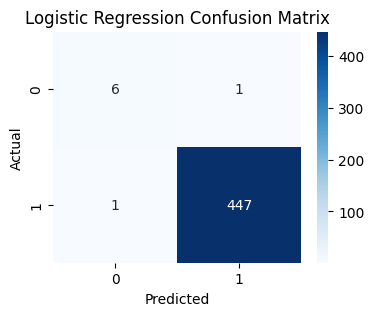

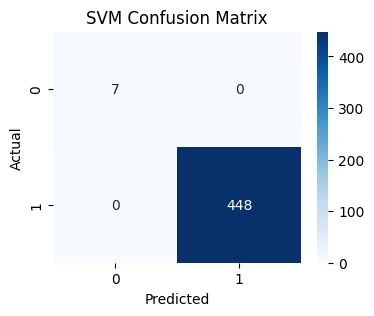

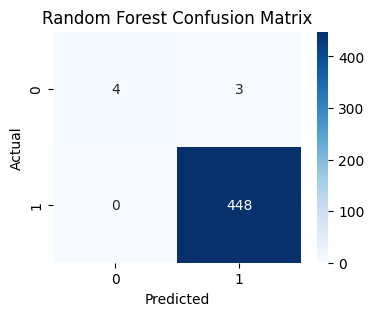

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

models = {
    "Logistic Regression": y_pred_lr,
    "SVM": y_pred_svm,
    "Random Forest": y_pred_rf
}

for name, preds in models.items():
    cm = confusion_matrix(y_test, preds)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    filename = name.lower().replace(" ", "_") + "_confusion_matrix.png"

    plt.savefig(
        f"../results/confusion_matrices/{filename}",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


## Deep Learning Model (LSTM)

In [22]:
#input and labels
X = beats
y = binary_labels

#Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [23]:
#Convert to PyTorch Tensors
import torch

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test, dtype=torch.long)

In [24]:
#Reshape for LSTM inputs
X_train_t = X_train_t.unsqueeze(-1)
X_test_t  = X_test_t.unsqueeze(-1)

#Single layer LSTM
import torch.nn as nn

class ECG_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=64,
            batch_first=True
        )
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

### Training Setup

In [31]:
model = ECG_LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Training loop
epochs = 10

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
 
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.7258
Epoch [2/10], Loss: 0.7146
Epoch [3/10], Loss: 0.7036
Epoch [4/10], Loss: 0.6927
Epoch [5/10], Loss: 0.6820
Epoch [6/10], Loss: 0.6713
Epoch [7/10], Loss: 0.6606
Epoch [8/10], Loss: 0.6498
Epoch [9/10], Loss: 0.6389
Epoch [10/10], Loss: 0.6277


In [33]:
#Evaluation 
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_t)
    _, y_pred_lstm = torch.max(test_outputs, 1)

#Computing metrics
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lstm.numpy()))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.98      1.00      0.99       448

    accuracy                           0.98       455
   macro avg       0.49      0.50      0.50       455
weighted avg       0.97      0.98      0.98       455



C:\Users\USER01\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\USER01\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\USER01\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

## Model Comparison & Error Analysis


### Error Analysis 

Number of misclassified beats: 7


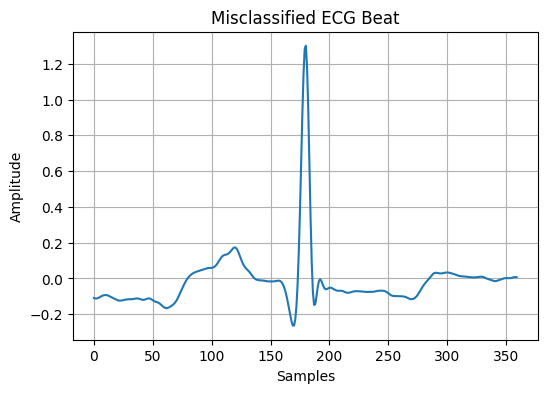

In [34]:
#Identify misclassified samples
mis_idx = np.where(y_pred_lstm.numpy() != y_test)[0]
print("Number of misclassified beats:", len(mis_idx))

#Visualizing misclassified heartbeats
plt.figure(figsize=(6, 4))
plt.plot(X_test[mis_idx[0]])
plt.title("Misclassified ECG Beat")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)
plt.savefig("../results/plots/error_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

Classical ML provides strong baseline performance using interpretable handcrafted features, while LSTM demonstrates the ability to learn temporal representations directly from ECG signals, with performance dependent on data quality and quantity.